In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import sobel, gaussian_filter

This function detects corner points in a grayscale image using a fast Harris Corner Detector implementation, optimized for better performance with NumPy and SciPy filters.

In [ ]:
from scipy.ndimage import uniform_filter

def harris_response_fast(gray_img, block_size=3, k=0.04):
    # Gradients
    Ix = sobel(gray_img, axis=1, mode='constant')
    Iy = sobel(gray_img, axis=0, mode='constant')

    # Compute gradient products
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy

    # Gaussian smoothing to reduce noise
    Ixx = gaussian_filter(Ixx, sigma=1)
    Iyy = gaussian_filter(Iyy, sigma=1)
    Ixy = gaussian_filter(Ixy, sigma=1)

    # FAST neighborhood summation (replaces nested loops)
    Sxx = uniform_filter(Ixx, size=block_size)
    Syy = uniform_filter(Iyy, size=block_size)
    Sxy = uniform_filter(Ixy, size=block_size)

    # Harris response
    det_M = Sxx * Syy - Sxy ** 2
    trace_M = Sxx + Syy
    R = det_M - k * (trace_M ** 2)

    return R


the Harris response to keep only strong, distinct corner points using local maximum comparison.

In [ ]:
def non_max_suppression(R, radius=2):
    corners = []
    h, w = R.shape
# Scan each pixel (excluding borders)
    for y in range(radius, h - radius):
        for x in range(radius, w - radius):

            # Extract local neighborhood
            local = R[y-radius:y+radius+1, x-radius:x+radius+1]

            # Keep pixel if it is local maximum and positive
            if R[y, x] == np.max(local) and R[y, x] > 0:
                corners.append((y, x))
    return corners


In [4]:
def adaptive_threshold(R, percentile=99):
    thresh = np.percentile(R, percentile)
    return R > thresh

This function combines Harris response, adaptive thresholding, and non-maximum suppression to detect reliable corner points in an image.

In [ ]:
def harris_corners_beginner(gray_img,
                            block_size=3,
                            k=0.04,
                            percentile=99,
                            nms_radius=2):
 # Compute Harris response
    R = harris_response_fast(gray_img, block_size, k)
# Apply adaptive thresholding
    mask = adaptive_threshold(R, percentile)
    R_thresh = R * mask
# Apply non-maximum suppression to get final corners
    corners = non_max_suppression(R_thresh, nms_radius)
    return corners

elects the strongest N corners by sorting them according to Harris scores.

In [6]:
def top_n_corners(corners, R, N=200):
    scored = [(y, x, R[y, x]) for y, x in corners]
    scored.sort(key=lambda x: x[2], reverse=True)
    return [(y, x) for y, x, _ in scored[:N]]

FAST corner score by comparing the intensity of surrounding pixels with the center pixel. Larger intensity differences increase the score, helping identify stronger corner candidates.

In [7]:
def fast_score(gray, y, x, circle, threshold):
    center = int(gray[y, x])
    score = 0

    for dx, dy in circle:
        p = int(gray[y + dy, x + dx])
        if abs(p - center) > threshold:
            score += abs(p - center)

    return score

In [ ]:
def fast_corners_beginner(gray_img, threshold=25, n=9):
    if gray_img.dtype != np.uint8:
        gray_img = gray_img.astype(np.uint8)

    h, w = gray_img.shape
    corners = []
# FAST 16-pixel circle pattern
    circle = [
        (0, 3), (1, 3), (2, 2), (3, 1), (3, 0), (3, -1), (2, -2), (1, -3),
        (0, -3), (-1, -3), (-2, -2), (-3, -1), (-3, 0), (-3, 1), (-2, 2), (-1, 3)
    ]

    for y in range(3, h - 3):
        for x in range(3, w - 3):
            center = int(gray_img[y, x])

            consec_b = consec_d = 0
            max_b = max_d = 0
# Compare circle pixels with center
            for dx, dy in circle:
                p = int(gray_img[y + dy, x + dx])
                if p > center + threshold:
                    consec_b += 1
                    consec_d = 0
                elif p < center - threshold:
                    consec_d += 1
                    consec_b = 0
                else:
                    consec_b = consec_d = 0

                max_b = max(max_b, consec_b)
                max_d = max(max_d, consec_d)

            if max_b >= n or max_d >= n:
                score = fast_score(gray_img, y, x, circle, threshold)
                corners.append((y, x, score))

    # NMS by score
    corners.sort(key=lambda x: x[2], reverse=True)
    return [(y, x) for y, x, _ in corners]

This implementation detects Harris corners across multiple image scales and returns the strongest features for better scale-invariant detection

In [9]:
import cv2
import numpy as np

def build_gaussian_pyramid(gray, num_levels=4, scale_factor=1.5):
    pyramid = [(gray, 1.0)]
    current = gray
    current_scale = 1.0

    for _ in range(1, num_levels):
        current_scale *= scale_factor
        new_size = (
            int(gray.shape[1] / current_scale),
            int(gray.shape[0] / current_scale)
        )
        current = cv2.resize(gray, new_size, interpolation=cv2.INTER_LINEAR)
        pyramid.append((current, current_scale))

    return pyramid


def harris_multiscale(gray,
                      num_levels=4,
                      scale_factor=1.5,
                      percentile=99,
                      nms_radius=2,
                      top_n=200):

    all_corners = []
    pyramid = build_gaussian_pyramid(gray, num_levels, scale_factor)

    for img, scale in pyramid:
        # Harris response at this scale
        R = harris_response_fast(img, block_size=3, k=0.04)

        # Adaptive threshold
        mask = adaptive_threshold(R, percentile)
        R_thresh = R * mask

        # NMS
        corners = non_max_suppression(R_thresh, nms_radius)

        # Rescale corners to original image
        for y, x in corners:
            y_orig = int(y * scale)
            x_orig = int(x * scale)
            if y_orig < gray.shape[0] and x_orig < gray.shape[1]:
                all_corners.append((y_orig, x_orig, R[y, x]))

    # Sort globally and keep top-N
    all_corners.sort(key=lambda x: x[2], reverse=True)
    return [(y, x) for y, x, _ in all_corners[:top_n]]


In [10]:
# Load image
#img_path = ""   # change to your image path
img = cv2.imread("box.png")

if img is None:
    raise ValueError("Image not found. Check the path.")

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype('float32')


In [ ]:
corners = harris_multiscale(
    gray,
    num_levels=4,   # Number of pyramid levels
    scale_factor=1.5,   # Downscaling factor between levels
    percentile=99,      # Adaptive threshold percentile
    nms_radius=2,       # Radius for non-maximum suppression
    top_n=300           # Radius for non-maximum suppression
)


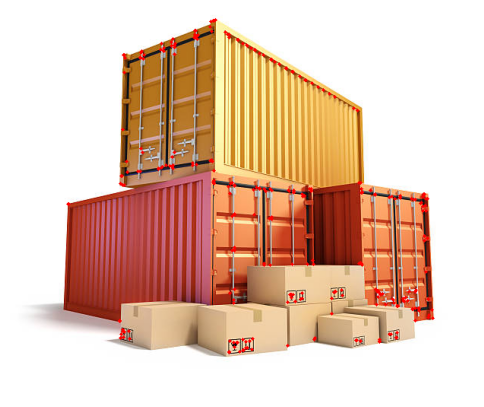

In [12]:
import matplotlib.pyplot as plt

vis = img.copy()
for y, x in corners:
    cv2.circle(vis, (x, y), 2, (0, 0, 255), -1)

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()